# FIT5202 Assignment 1 : Analysing eCommerce Data

## Table of Contents
* 
    * [Part 1 : Working with RDD](#part-1)
        * [1.1 Data Preparation and Loading](#1.1)
        * [1.2 Data Partitioning in RDD](#1.2)
        * [1.3 Query/Analysis](#1.3)
    * [Part 2 : Working with DataFrames](#2-dataframes)
        * [2.1 Data Preparation and Loading](#2-dataframes)
        * [2.2 Query/Analysis](#2.2)
    * [Part 3 :  RDDs vs DataFrame vs Spark SQL](#part-3)

# Part 1 : Working with RDDs <a class="anchor" name="part-1"></a>
## 1.1 Working with RDD
In this section, you will need to create RDDs from the given datasets, perform partitioning in these RDDs and use various RDD operations to answer the queries for retail analysis. 

### 1.1.1 Data Preparation and Loading <a class="anchor" name="1.1"></a>
Write the code to create a SparkContext object using SparkSession. To create a SparkSession you first need to build a SparkConf object that contains information about your application, use Melbourne time as the session timezone. Give an appropriate name for your application and run Spark locally with as many working processors as logical cores on your machine. 

In [98]:
from datetime import datetime, date
from pyspark.sql.functions import col, udf, to_date, hour, col, udf, collect_list, row_number
from pyspark.sql.functions import round as spark_round
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.functions import count as spark_count
from pyspark.sql.types import StringType, DateType, IntegerType, FloatType, StringType, TimestampType
from pyspark.sql.window import Window
import matplotlib
import matplotlib.pyplot as plt
import math

In [99]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "eCommerce Analysis"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

#TODO : Initialize Spark Session and create a SparkContext Object
# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

# Set Melbourne time as timezone
spark.conf.set("spark.sql.session.timeZone", "Australia/Sydney")

1.1.2 Load CUPS csv files into four RDDs.

We first load the CUPS csv files

In [100]:
category_rdd = sc.textFile('sales/category.csv')
product_rdd = sc.textFile('sales/product.csv')
sales_rdd = sc.textFile('sales/sales.csv')
users_rdd = sc.textFile('users/users.csv')

Then we perform data processing

In [101]:
# separate the field values into multiple columns
category_rdd = category_rdd.map(lambda x: x.split(','))
product_rdd = product_rdd.map(lambda x: x.split(','))
sales_rdd = sales_rdd.map(lambda x: x.split(','))
users_rdd = users_rdd.map(lambda x: x.split(','))

1.1.3 For each RDD, remove the header rows and display the total count and first 10 records. (Hint: You can use csv.reader to parse rows into RDDs.)

We first remove the header rows

In [102]:
# Retrieve header values
category_header = category_rdd.first()
product_header = product_rdd.first()
sales_header = sales_rdd.first()
users_header = users_rdd.first()

In [103]:
# Filter out header values
category_rdd = category_rdd.filter(lambda x: x != category_header)
product_rdd = product_rdd.filter(lambda x: x != product_header)
sales_rdd = sales_rdd.filter(lambda x: x != sales_header)
users_rdd = users_rdd.filter(lambda x: x != users_header)

Print total count for each RDD

In [36]:
print("Total count on RDDs")
print(f"category_rdd: {category_rdd.count()}")
print(f"product_rdd: {product_rdd.count()}")
print(f"sales_rdd: {sales_rdd.count()}")
print(f"users_rdd: {users_rdd.count()}")

Total count on RDDs
category_rdd: 1464
product_rdd: 208290
sales_rdd: 6848824
users_rdd: 15639803


In [37]:
print(f"category_rdd first 10 records:\n{category_rdd.take(10)}")
print()
print(f"product_rdd first 10 records:\n{product_rdd.take(10)}")

category_rdd first 10 records:
[['2090971686529663114', 'appliances.environment.vacuum'], ['2232732116498514828', 'apparel.jeans'], ['2232732109628244704', 'apparel.shirt'], ['2232732103294845523', 'apparel.shoes.step_ins'], ['2232732086500851925', 'apparel.scarf'], ['2232732100660822557', 'country_yard.cultivator'], ['2053013558282682943', 'construction.tools.drill'], ['2053013562527318829', 'furniture.living_room.cabinet'], ['2110937143172923797', 'construction.tools.light'], ['2074462942123786261', 'kids.toys']]

product_rdd first 10 records:
[['100168127', '2053013554096767303', '', '30.8171196068388'], ['7101887', '2232732103764607583', '', '33.6457534471799'], ['100058603', '2053013555438944659', '', '32.1982006550096'], ['100007811', '2232732112782361392', 'etro', '300.111251624047'], ['26400508', '2053013553056579841', '', '139.458912588293'], ['100215722', '2134905019189691101', '', '4.15035271832127'], ['32402016', '2232732115777094520', '', '5.90104832419485'], ['13201248', 

In [38]:
print(f"sales_rdd first 10 records:\n{sales_rdd.take(10)}")
print()
print(f"users_rdd first 10 records:\n{users_rdd.take(10)}")

sales_rdd first 10 records:
[['338156802', '2020-03-27 02:03:48.000000 +00:00', '4804056', '171.56', '513119357', '0ad58441-9db9-48bd-9ee7-accf603f06e0'], ['338156808', '2020-03-27 02:03:49.000000 +00:00', '1005223', '209.53', '522277649', '2ecb2725-2c40-4acb-8ef1-05e39ea4c2cc'], ['338156913', '2020-03-27 02:04:11.000000 +00:00', '1005212', '174.25', '632847510', '43609582-1818-4885-bd72-3791f3a4ec93'], ['338156921', '2020-03-27 02:04:13.000000 +00:00', '1005236', '231.15', '626579483', 'bbf972ef-8f8d-4a33-bcbd-ac09af67ea40'], ['338156953', '2020-03-27 02:04:18.000000 +00:00', '1005212', '174.25', '633245502', '90166e0d-d7da-4997-b479-bc3a0fd724d6'], ['338156985', '2020-03-27 02:04:24.000000 +00:00', '100132156', '47.5', '541680528', '4cd111cc-8716-4720-b7e3-bc3c8ddce98f'], ['338157055', '2020-03-27 02:04:37.000000 +00:00', '3500009', '290.84', '618162129', 'd0bda424-a759-4941-b9be-5091c28009db'], ['338157122', '2020-03-27 02:04:48.000000 +00:00', '2300214', '386.08', '626601722', 'ce9

**1.1.4 Drop unnecessary columns from RDDs: firstname, lastname, user_session.**

We first Determine which index's the store column values

In [39]:
for index, field in enumerate(users_header):
    print(f"index: {index}, field: {field}")

index: 0, field: user_id
index: 1, field: firstname
index: 2, field: lastname
index: 3, field: dob
index: 4, field: address
index: 5, field: postcode
index: 6, field: state
index: 7, field: sex
index: 8, field: suburb


*firstname and lastname are index 1 and 2 respectively*

In [40]:
for index, field in enumerate(sales_header):
    print(f"index: {index}, field: {field}")

index: 0, field: id
index: 1, field: sales_timestamp
index: 2, field: product_id
index: 3, field: price
index: 4, field: user_id
index: 5, field: user_session


*user_session is index 5*

Next, the requested columns are dropped in the `users_rdd` and `sales_rdd` RDDs

In [104]:
users_rdd = users_rdd.map(lambda x: x[:1]+x[3:])
sales_rdd = sales_rdd.map(lambda x: x[:5])

We also remove the duplicate product IDs and Category IDs found in `product_rdd` and `category_rdd` respectively

In [105]:
# Retrieve set of largest category IDs for each product id
unique_product_categories = set(product_rdd.map(lambda x: [x[0] , int(x[1])]).groupByKey().mapValues(lambda x: max(x)).collect())
bd_unique_product_categories = sc.broadcast(unique_product_categories)

# Create function to filter product_rdd rows in this set
def filter_largest_category(row):
    val_tuple = (row[0], int(row[1]))
    return val_tuple in bd_unique_product_categories.value

# Apply filter
product_rdd = product_rdd.filter(filter_largest_category)

# Retrieve set of longest string of brand for each product id
unique_product_brands = product_rdd.map(lambda x: [(x[0], x[1]), x[2]])\
        .groupByKey().mapValues(max)\
        .map(lambda x: (x[0][0], x[0][1], x[1])).collect()
bd_unique_product_brands = sc.broadcast(unique_product_brands)

# Create function to filter product_rdd rows in this set
def filter_longest_brand(row):
    val_tuple = (row[0], row[1], row[2])
    return val_tuple in bd_unique_product_brands.value

# Apply filter
product_rdd = product_rdd.filter(filter_longest_brand)

In [106]:
# Create UDF function to retrieve the longest category code string
def get_longest_string(ls):
    res = ""
    for val in ls:
        if len(val) > len(res):
            res = val
    return res

In [107]:
unique_categories = set(category_rdd.groupByKey().mapValues(get_longest_string).collect())
broadcast_unique_categories = sc.broadcast(unique_categories)

def filter_categories(row):
    val_tuple = (row[0], row[1])
    return val_tuple in broadcast_unique_categories.value

category_rdd = category_rdd.filter(filter_categories)

### 1.2 Data Partitioning in RDD <a class="anchor" name="1.2"></a>
1.2.1 For each RDD, print out the total number of partitions and the number of records in each partition. Answer the following questions: How many partitions do the above RDDs have? How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy? Can you explain why it will be partitioned in this number? If I only have one single core CPU in my PC, what is the default partition's number? (Hint: search the Spark source code to try to answer this question.) Write code and your explanation in Markdown cells.

<strong>How many partitions do the above RDDs have? 

First, we create a function to record number of records in each partition

In [108]:
def get_partition_count(partition):
    count = 0
    for x in partition:
        count += 1
    yield count

def output_partition_res(res):
    for index, count in enumerate(partition_counts):
        print(f"partition {index}: {count} records")

In [46]:
print("category_rdd partitions")
partition_counts = category_rdd.mapPartitions(get_partition_count).collect()
output_partition_res(partition_counts)

category_rdd partitions
partition 0: 647 records
partition 1: 611 records


In [12]:
print("product_rdd partitions")
partition_counts = product_rdd.mapPartitions(get_partition_count).collect()
output_partition_res(partition_counts)

product_rdd partitions
partition 0: 81738 records
partition 1: 77586 records


In [13]:
print("sales_rdd partitions")
partition_counts = sales_rdd.mapPartitions(get_partition_count).collect()
output_partition_res(partition_counts)

sales_rdd partitions
partition 0: 315832 records
partition 1: 315940 records
partition 2: 316009 records
partition 3: 319748 records
partition 4: 319808 records
partition 5: 319827 records
partition 6: 319861 records
partition 7: 319855 records
partition 8: 317174 records
partition 9: 316760 records
partition 10: 316656 records
partition 11: 316733 records
partition 12: 316682 records
partition 13: 316607 records
partition 14: 316439 records
partition 15: 316229 records
partition 16: 316253 records
partition 17: 316229 records
partition 18: 316133 records
partition 19: 316127 records
partition 20: 316023 records
partition 21: 187899 records


In [14]:
print("users_rdd partitions")
partition_counts = users_rdd.mapPartitions(get_partition_count).collect()
output_partition_res(partition_counts)

users_rdd partitions
partition 0: 407684 records
partition 1: 407751 records
partition 2: 407663 records
partition 3: 407640 records
partition 4: 407740 records
partition 5: 407698 records
partition 6: 407764 records
partition 7: 407723 records
partition 8: 407732 records
partition 9: 407782 records
partition 10: 407851 records
partition 11: 407787 records
partition 12: 407659 records
partition 13: 407782 records
partition 14: 407827 records
partition 15: 407766 records
partition 16: 407888 records
partition 17: 407701 records
partition 18: 407788 records
partition 19: 407748 records
partition 20: 407745 records
partition 21: 407862 records
partition 22: 407724 records
partition 23: 407781 records
partition 24: 407785 records
partition 25: 407745 records
partition 26: 407680 records
partition 27: 407655 records
partition 28: 407691 records
partition 29: 407780 records
partition 30: 407737 records
partition 31: 407740 records
partition 32: 407693 records
partition 33: 407728 records
par

<strong>How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy?

The default partitioning strategy used is random-equal partitioning strategy.The RDDs are partitioned based on the number of cores we have in our CPU. Since my CPU has 6 cores, the default partition is 6. But when the data is not large, it does not require that many partitions.

<strong>Can you explain why it will be partitioned in this number? If I only have one single core CPU in my PC, what is the default partition's number? (Hint: search the Spark source code to try to answer this question)

In [ ]:
## INCOMPLETE #######################################################

The default partition number will be 1. This is because PySpark is configured to partition the data based on the number of CPU cores in a PC. PySpark makes full use of the CPU processing cores to perform optimised parallel processing on any queries or operations we execute.

. . For a PC with only a single core CPU, then there will only be one partition.

<strong>1.2.2. Create a user defined function (UDF) to transform category_code to capitalized words. (e.g. apparel.shoes.ballet_shoes shall be converted to “Apparel Shots Ballet_shoes).

In [ ]:
## INCOMPLETE #######################################################

Do we use a user-defined function on an RDD? is it fine to just use the function?

Firstly, we create the user defined function

In [109]:
def category_format(x):
    category_code = x
    words = category_code.split('.')
    for i in range(len(words)):
        words[i] = words[i].capitalize()
    return ' '.join(words)
category_format_udf = udf(category_format, StringType())

In [110]:
category_rdd = category_rdd.map(lambda x: (x[0], category_format(x[1])))

<strong>1.2.3. Join Product and Category RDDs and Create a new key value RDD, using brand as the key and all of the categories of that brand as the value. Print out the first 5 records of the key-value RDD.

We retrieve relevant column values from `product_rdd` and `category_rdd`

In [111]:
product_tuple_rdd = product_rdd.map(lambda x: tuple(x[1:3]))
category_tuple_rdd = category_rdd.map(lambda x: tuple(x))

We perform a join operation on the `category_id` and rearrange column RDD to retrieve brand to category_code pair values

In [112]:
product_category_join = category_tuple_rdd.join(product_tuple_rdd)
product_category_join = product_category_join.map(lambda x: (x[1][1], x[1][0]))

Lastly, we perform a group by operation on `brand` and return a list of `category_code` for each brand

In [113]:
brand_categories_rdd = product_category_join.groupByKey().mapValues(lambda x: tuple(set(x)))
brand_categories_rdd.take(5)

[('domani-spa',
  ('Furniture Living_room Cabinet',
   'Electronics Clocks',
   'Furniture Bathroom Bath')),
 ('',
  ('Sport Tennis',
   'Apparel Shirt',
   'Appliances Kitchen Blender',
   'Appliances Kitchen Juicer',
   'Appliances Environment Water_heater',
   'Furniture Living_room Cabinet',
   'Apparel Shoes Keds',
   'Computers Peripherals Printer',
   'Appliances Kitchen Coffee_grinder',
   'Stationery Cartrige',
   'Kids Toys',
   'Electronics Telephone',
   'Apparel Underwear',
   'Apparel Shoes Slipons',
   'Computers Components Cdrw',
   'Electronics Audio Subwoofer',
   'Computers Components Sound_card',
   'Appliances Kitchen Washer',
   'Apparel Jacket',
   'Furniture Universal Light',
   'Construction Tools Welding',
   'Electronics Camera Photo',
   'Computers Components Videocards',
   'Apparel Trousers',
   'Kids Dolls',
   'Construction Tools Painting',
   'Kids Carriage',
   'Construction Tools Saw',
   'Country_yard Watering',
   'Furniture Living_room Sofa',
   'C

### 1.3 Query/Analysis <a class="anchor" name="1.3"></a>
For this part, write relevant RDD operations to answer the following queries.

**1.3.1 Calculate the average daily sales for each year, each month. Print the results as the following format(see assignment specification).**

Firstly, we convert sales_timestamp column into datetime data type. Afterwards, we can extract the sales year, month and day

In [114]:
timestamp_format = "%Y-%m-%d %H:%M:%S.%f %z"
daily_sales_rdd = sales_rdd.map(lambda x: [x[0]] + [datetime.strptime(x[1], timestamp_format)] + x[2:])
daily_sales_rdd = daily_sales_rdd.map(lambda x: ((x[1].year, x[1].month, x[1].day),1))

Then the total number of sales is calculated for each day using `groupByKey` function

In [115]:
daily_sales_rdd = daily_sales_rdd.groupByKey().mapValues(len)

After calculating total daily sales, we can then perform another group-by function for each year, each month to retrieve the average total daily sales

In [116]:
avg_sales_rdd = daily_sales_rdd.map(lambda x: ((x[0][0], x[0][1]), x[1]))
# group by month, year
avg_sales_rdd = avg_sales_rdd.groupByKey().mapValues(lambda x: round(sum(x)/len(x),2))
# flatten the results
avg_sales_rdd = avg_sales_rdd.map(lambda x: [x[0][0], x[0][1], x[1]])

Our calculation of avg daily sales is then formally outputted using dataframe

In [23]:
avg_sales_df = avg_sales_rdd.toDF()\
    .withColumnRenamed("_1","year").withColumnRenamed("_2","month").withColumnRenamed("_3","avg sales")\
    .orderBy(col("year").asc(), col("month").asc())
avg_sales_df.show()

+----+-----+---------+
|year|month|avg sales|
+----+-----+---------+
|2019|   10| 23962.87|
|2019|   11| 31618.59|
|2019|   12| 37485.42|
|2020|    1| 27833.57|
|2020|    2| 41389.24|
|2020|    3| 33062.39|
|2020|    4|  32225.3|
+----+-----+---------+



**1.3.2 Find 10 of the best selling brands. You should display the brand and total revenue in the result.**

We first convert the price column from string to float data type

In [117]:
sales_rdd = sales_rdd.map(lambda x: x[:3] + [float(x[3])] + x[4:])

In [118]:
sales_mod_rdd = sales_rdd.map(lambda x: (x[2], x[3]))
product_mod_rdd = product_rdd.map(lambda x: (x[0], x[2]))

In [119]:
join_rdd = product_mod_rdd.join(sales_mod_rdd)
join_rdd = join_rdd.map(lambda x: [x[1][0], x[1][1]])

In [120]:
brand_revenue = join_rdd.groupByKey().mapValues(sum)
brand_revenue = brand_revenue.sortBy(lambda x: -x[1])

In [121]:
brand_revenue.take(10)

[('apple', 929385237.8800286),
 ('samsung', 425990400.8197582),
 ('xiaomi', 91863355.39001285),
 ('', 62416824.529973395),
 ('huawei', 42308406.85998937),
 ('lg', 38278431.37999987),
 ('sony', 28542732.010002367),
 ('lucente', 28392306.44000093),
 ('acer', 27610850.919998948),
 ('lenovo', 27212179.640004687)]

## Part 2. Working with DataFrames <a class="anchor" name="2-dataframes"></a>
In this section, you will need to load the given datasets into PySpark DataFrames and use DataFrame functions to answer the queries.
### 2.1 Data Preparation and Loading

**2.1.1. Load CUPS into four separate dataframes. When you create your dataframes, please refer to the metadata file and think about the appropriate data type for each columns (Note: Initially, you should read date/time related column as the string type).**

In [122]:
category_df = spark.read.csv('sales/category.csv', header=True)
product_df = spark.read.csv('sales/product.csv', header=True)
sales_df = spark.read.csv('sales/sales.csv', header=True)
users_df = spark.read.csv('users/users.csv', header=True)

**2.1.2 Display the schema of the four dataframes.**

We first transform the dataframes and convert the columns to the most appropriate data types

In [123]:
# change product_df to have correct data types
product_df_clean = product_df.withColumn("product_id", col("product_id").cast(IntegerType()))\
    .withColumn("avg_cost", col("avg_cost").cast(FloatType()))\

# change sales_df to have correct data types
sales_df_clean = sales_df.withColumn("id", col("id").cast(IntegerType()))\
    .withColumn("sales_timestamp", col("sales_timestamp").cast(TimestampType()))\
    .withColumn("product_id", col("product_id").cast(IntegerType()))\
    .withColumn("price", col("price").cast(FloatType()))\
    .withColumn("user_id", col("user_id").cast(IntegerType()))

# change users_df to have correct data types
users_df_clean = users_df.withColumn("user_id", col("user_id").cast(IntegerType()))\
    .withColumn("dob", to_date(col("dob"),"d-M-yyyy"))\
    .withColumn("postcode", col("postcode").cast(IntegerType()))

The schemas are then printed out

In [31]:
print('category_df schema')
category_df.printSchema()

category_df schema
root
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)



In [6]:
print('product_df schema')
product_df.printSchema()

product_df schema
root
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- avg_cost: string (nullable = true)



In [7]:
print('sales_df schema')
sales_df.printSchema()

sales_df schema
root
 |-- id: string (nullable = true)
 |-- sales_timestamp: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



In [8]:
print('users_df schema')
users_df.printSchema()

users_df schema
root
 |-- user_id: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- address: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- state: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- suburb: string (nullable = true)



### 2.2 QueryAnalysis  <a class="anchor" name="2.2"></a>
Implement the following queries using dataframes. You need to be able to perform operations like filtering, sorting, joining and group by using the functions provided by the DataFrame API.   

**2.2.1. Transform the 'sales_time' column in the sales dataframe to the date type; extract the hour in sales_date and create a new column “sales_hour”; after that, show the schema.**

Firstly, convert values in sales_timestamp from String to Timestamp

In [124]:
sales_df_mod = sales_df_clean.withColumn("sales_timestamp",sales_df_clean.sales_timestamp.cast("timestamp"))

Secondly, create a new column `sales_date` based on data from `sales_timestamp`

In [125]:
sales_df_mod = sales_df_mod.withColumn("sales_date", sales_df_mod.sales_timestamp.cast("date"))

Thirdly, we create a new column `sales_hour` which retrieves the hour value from `sales_timestamp`

In [126]:
sales_df_mod = sales_df_mod.withColumn("sales_hour", hour(sales_df_mod.sales_timestamp))

We then print the schema

In [127]:
sales_df_clean = sales_df_mod
sales_df_clean.printSchema()

root
 |-- id: integer (nullable = true)
 |-- sales_timestamp: timestamp (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- sales_date: date (nullable = true)
 |-- sales_hour: integer (nullable = true)



<strong>2.2.2. Calculate total sales for each hour, sort your result based on each hour’s sales in a descending order. Print out the sales_hour and total_sales columns.</strong>

<div style='background-color:red'><strong>Is total sales in meaning total number of sales OR total amount from sales?</strong></div>

In [128]:
sales_by_hour_df = sales_df_clean.groupBy(sales_df_clean.sales_hour).count().withColumnRenamed("count", "total_sales")
sales_by_hour_df = sales_by_hour_df.orderBy(sales_by_hour_df.sales_hour.desc())

In [141]:
sales_by_hour_df.show(24)

+----------+-----------+
|sales_hour|total_sales|
+----------+-----------+
|        23|     409010|
|        22|     443598|
|        21|     482266|
|        20|     503621|
|        19|     503462|
|        18|     483906|
|        17|     461138|
|        16|     421224|
|        15|     351961|
|        14|     237628|
|        13|     116993|
|        12|      51705|
|        11|      32010|
|        10|      30074|
|         9|      42038|
|         8|      64411|
|         7|     102286|
|         6|     162968|
|         5|     225583|
|         4|     287796|
|         3|     323915|
|         2|     352587|
|         1|     372471|
|         0|     386173|
+----------+-----------+



**2.2.3.Find 10 most profitable categories (profit can be simply defined as price - avg_cost). Print out the category name and total profit. Please print the category name in capitalized word format(hint: you can reuse the UDF defined in part 1.)**

To find the 10 most profitable categories, we will need to perform a join operation with `category_df`, `product_df` and `sales_df`

We first remove the duplicate IDs in `category_df` by choosing the character code with the longest length.

In [129]:
longest_string_udf = udf(get_longest_string, StringType())
# Used groupby function on df and aggregate using UDF function
deduped_category_df = category_df.groupBy("category_id").\
        agg(longest_string_udf(collect_list("category_code")).alias("category_code"))

We then remove the duplicate product IDs in `product_df_clean` by selecting the instance with the largest category ID. We do this by using a combination of `row_number` function and `Window` to provide a ranking to each product id based on category id value

In [130]:
# rank product_id by largest category_id and brand 
product_dept = Window.partitionBy("product_id").orderBy([col("category_id").desc(), col("brand").desc()])
# filter to get first rank
deduped_product_df = product_df_clean.withColumn("row", row_number().over(product_dept))\
    .filter(col("row") == 1)\
    .drop("row")\
    .orderBy(col("product_id").asc())

We now join `dedupated_category_df`, `deduped_product_df` and `sales_df` to gather all the data we need to calculate sales profit

In [131]:
join_df = sales_df_clean.join(deduped_product_df, sales_df_clean.product_id == deduped_product_df.product_id)\
        .drop(sales_df_clean.product_id)
join_df = join_df.join(deduped_category_df, join_df.category_id == deduped_category_df.category_id)\
        .drop(deduped_category_df.category_id)

We define a UDF function to calculate the profit

In [132]:
profit_udf = udf(lambda price, avg_cost: price - avg_cost, FloatType())

We calculate the profit made for each sale, and then aggregate the table to get the total profit grouped by category name

In [133]:
# Calculate profit
category_profits = join_df.select(col("category_code"), profit_udf(join_df.price, join_df.avg_cost).alias("profit"))
# Sum profit grouped by category code
category_profits = category_profits.groupBy("category_code").sum("profit")
# format column and values
category_profits = category_profits.withColumnRenamed("sum(profit)","total_profit")

Use `category_formatter` UDF function to transform `category_code`

In [134]:
def category_format(category_code):
    words = category_code.split('.')
    for i in range(len(words)):
        words[i] = words[i].capitalize()
    return ' '.join(words)
#     yield ' '.join(words)
category_format_udf = udf(category_format, StringType())

category_profits = category_profits.withColumn("category_code", category_format_udf(col("category_code")))\
    .orderBy(category_profits.total_profit.desc())

Finally, we output the top 10 most profitable categories

In [139]:
res = category_profits.limit(10)

In [140]:
res.show(truncate=False)

+--------------------------------+-------------------+
|category_code                   |total_profit       |
+--------------------------------+-------------------+
|Construction Tools Light        |6.125602823422313E7|
|Appliances Personal Massager    |5196086.414781928  |
|Appliances Kitchen Refrigerators|4283076.883982658  |
|Others                          |4002670.567923337  |
|Computers Notebook              |2805912.1956562996 |
|Electronics Clocks              |2113755.9995524883 |
|Appliances Kitchen Washer       |1432456.2404248714 |
|Sport Ski                       |1283055.6067435145 |
|Appliances Environment Vacuum   |1171350.9181756973 |
|Electronics Smartphone          |1021107.1154553294 |
+--------------------------------+-------------------+



**2.2.4. Use DataFrame filters to find all transactions sold at loss (defined as price < avg_cost), calculate 10 worst loss margin in percentage. (margin is defined as (price - avg_cost)/avg_cost; if price - avg_cost > 0, it’s call a profit margin; otherwise a loss margin)**

In [142]:
product_sales_df = sales_df_clean.join(deduped_product_df, \
                                       sales_df_clean.product_id == deduped_product_df.product_id,\
                                      how = 'left')\
        .drop(product_df.product_id)

In [143]:
loss_margin_df = product_sales_df.withColumn("loss_margin", spark_round((col("price") - col("avg_cost"))/col("avg_cost")*100,2))\
    .orderBy(col("loss_margin").asc())
loss_margin_df = loss_margin_df.select("id", "price", "avg_cost", "loss_margin")

In [144]:
loss_margin_df.show(10)

+---------+-----+---------+-----------+
|       id|price| avg_cost|loss_margin|
+---------+-----+---------+-----------+
|204037762| 4.61|603.00494|     -99.24|
|204017856| 4.61|603.00494|     -99.24|
|396531551| 5.15| 512.3399|     -98.99|
|394075934| 5.15| 512.3399|     -98.99|
|394083902| 5.15| 512.3399|     -98.99|
|394106370| 5.15| 512.3399|     -98.99|
|394112198| 5.15| 512.3399|     -98.99|
|394129754| 5.15| 512.3399|     -98.99|
|396544717| 5.15| 512.3399|     -98.99|
|396598353| 5.15| 512.3399|     -98.99|
+---------+-----+---------+-----------+
only showing top 10 rows



**2.2.5. Draw a barchart to show total sales from different states in each year.**

<div style="background-color:red"><strong>total sales = total number of transations? or total price</strong><div>

We perform a left join between `sales_df` and `users_df` to receive state information for each sale transaction

In [145]:
user_sales_df = sales_df_clean.join(users_df_clean, \
                                    sales_df_clean.user_id == users_df_clean.user_id, how="left")\
        .drop(users_df_clean.user_id)

We then group the table by state and calculate the total count, which refers to the total sales made for each state

In [146]:
state_total_sales_df = user_sales_df.groupBy(col("state")).count()

 The Pyspark dataframe is then converted into a Pandas dataframe to plot it into a bar graph

<Axes: xlabel='state'>

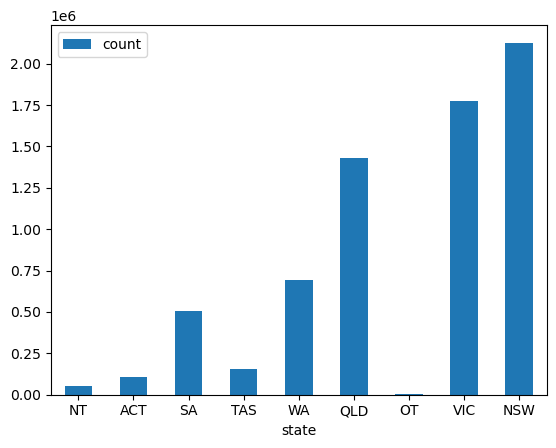

In [27]:
total_sales_pd = state_total_sales_df.toPandas()
total_sales_pd.plot.bar(x='state', y='count', rot=0)

**2.2.6. Draw a scatter plot of customer age and their total spending with MOTH. To limit the number of datapoints, you may show the top 1000 “most valuable” customers only. You may also use log scale for the XY axis.**

In [147]:
def calc_age(dob):
    today = date.today()
    delta = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return delta

calc_age_udf = udf(calc_age, IntegerType())

In [38]:
age_spending_df = user_sales_df.select(col("user_id"), col("dob"), col("price"), calc_age_udf(col("dob")).alias("age"))
age_spending_df = age_spending_df.groupBy(col("user_id"), col("age")).sum("price")
age_spending_df = age_spending_df.withColumnRenamed("sum(price)", "total_spending")
age_spending_df = age_spending_df.orderBy(age_spending_df.total_spending.desc())
age_spending_df = age_spending_df.limit(1000)

In [30]:
age_spending_pd = age_spending_df.toPandas()

<Axes: xlabel='age', ylabel='total_spending'>

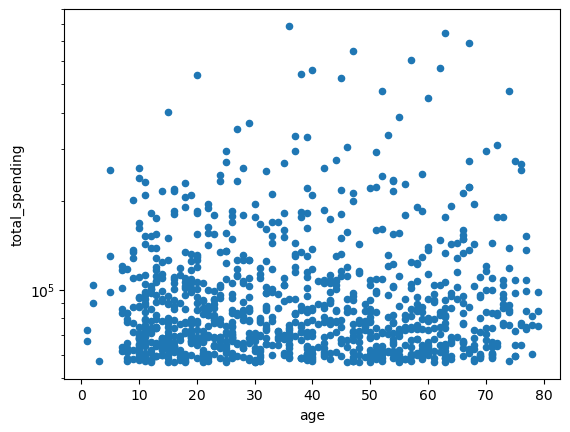

In [31]:
age_spending_pd.plot.scatter(x='age', y='total_spending', logy=True)

### Part 3 RDDs vs DataFrame vs Spark SQL (15%) <a class="anchor" name="part-3"></a>
Implement the following queries using RDDs, DataFrames in SparkSQL separately. Log the  time taken for each query in each approach using the “%%time” built-in magic command in Jupyter Notebook and discuss the performance difference between these 3 approaches. 


#### Query: Find top 100 most popular products (by total sales) among user age group 20-40, group by brand, and show total sales revenue of each brand.

#### 3.1. RDD Implementation

LOG THE TIME TAKEN

In [148]:
val1 = users_rdd.filter(lambda x: x[1] == 'Unknown').map(lambda x: x[:1] + x[2:])
val2 = users_rdd.filter(lambda x: x[1] != 'Unknown')
users_mod_rdd = val1.union(val2)

In [149]:
users_mod_rdd = users_mod_rdd.map(lambda x: x[:1] + [datetime.strptime(x[1], "%d-%m-%Y")] + x[2:])

In [150]:
users_mod_rdd = users_mod_rdd.map(lambda x: x[:1] + [calc_age(x[1])])

In [151]:
# filter for users between the age 20-40 inclusive
users_mod_rdd = users_mod_rdd.filter(lambda x: x[-1] >= 20).filter(lambda x: x[-1] <= 40)

In [152]:
sales_mod_rdd = sales_rdd.map(lambda x: [x[4], (x[2], x[3])])

In [153]:
join_rdd = sales_mod_rdd.join(users_mod_rdd)

In [154]:
product_sales_rdd = join_rdd.map(lambda x: x[1][0][:])
# group by product id and aggregate to get total number of sales and total sales revenue
product_sales_rdd = product_sales_rdd.groupByKey().mapValues(lambda x: (len(x),sum(x)) ).sortBy(lambda x: -x[1][0])
# Retrieve 100 most popular products based on total number of sales
product_sales_rdd = product_sales_rdd.zipWithIndex().filter(lambda x: x[1]<100).map(lambda x: x[0][:])

In [155]:
product_mod_rdd = product_rdd.map(lambda x: [x[0], x[2]])
brand_join_rdd = product_sales_rdd.join(product_mod_rdd).map(lambda x: [x[1][1], x[1][0][1]])
brand_revenue_rdd = brand_join_rdd.groupByKey().mapValues(sum).sortBy(lambda x: -x[1])

In [156]:
brand_revenue_rdd.collect()

[('apple', 225697189.42999905),
 ('samsung', 87188246.74999748),
 ('xiaomi', 14225832.960000172),
 ('huawei', 7733847.580000031),
 ('oppo', 5075319.259999837),
 ('sony', 1742158.7900000412),
 ('lenovo', 920414.8700000199),
 ('artel', 734490.7199999966)]

#### 3.2. DataFrame Implementation

Before performing the query, we need to first pre-process the data. Firstly is to calculate the age of each user

In [157]:
users_df_clean = users_df_clean.withColumn("age", calc_age_udf(col("dob")))
filtered_users_df = users_df_clean.filter(col('age')>=20).filter(col('age')<=40)

In [158]:
join_df = sales_df_clean.join(filtered_users_df, sales_df_clean.user_id==filtered_users_df.user_id, how='inner')\
        .drop(filtered_users_df.user_id)

In [159]:
product_sales_df = join_df.groupBy(col("product_id")).agg(
    spark_count("*").alias("total_sales"),
    spark_sum("price").alias("sales_revenue")
)

product_sales_df = product_sales_df.orderBy(col("total_sales").desc()).limit(100)

In [160]:
brand_join_df = product_sales_df.join(deduped_product_df,\
                     product_sales_df.product_id == deduped_product_df.product_id,\
                     how='inner')\
        .drop(deduped_product_df.product_id)

brand_revenue_df = brand_join_df.groupBy(col("brand")).agg(spark_sum("sales_revenue").alias("total_revenue"))\
                    .orderBy(col("total_revenue").desc())

In [161]:
brand_revenue_df.show()

+-------+--------------------+
|  brand|       total_revenue|
+-------+--------------------+
|  apple|2.2569718955223083E8|
|samsung| 8.718824659664154E7|
| xiaomi|1.4225832972858429E7|
| huawei|   7733847.568565369|
|   oppo|   5075319.240287781|
|   sony|   1742158.806427002|
| lenovo|   920414.8711090088|
|  artel|   734490.7239379883|
+-------+--------------------+



#### 3.3. Spark SQL Implementation

We convert our pyspark dataframes into spark SQL views

In [162]:
deduped_product_df.createOrReplaceTempView("product_sql")
sales_df_clean.createOrReplaceTempView("sales_sql")
users_df_clean.createOrReplaceTempView("users_sql")

In [164]:
brand_revenue_sql = spark.sql(
"""
with filtered_users as 
(
    SELECT user_id
    FROM users_sql
    WHERE age >= 20 and age <= 40
)
, popular_products as 
(
    SELECT product_id, count(*) as total_sales, sum(price) as total_revenue 
    FROM sales_sql
    JOIN filtered_users
    ON sales_sql.user_id = filtered_users.user_id
    GROUP BY product_id
    ORDER BY total_sales desc
    LIMIT 100
)
SELECT brand, sum(total_revenue) as total_revenue
FROM popular_products
JOIN product_sql
ON popular_products.product_id = product_sql.product_id
GROUP BY brand
ORDER BY total_revenue desc
"""
)

In [165]:
brand_revenue_sql.show()

+-------+--------------------+
|  brand|       total_revenue|
+-------+--------------------+
|  apple|2.2569718955223083E8|
|samsung| 8.718824659664154E7|
| xiaomi|1.4225832972858429E7|
| huawei|   7733847.568565369|
|   oppo|   5075319.240287781|
|   sony|   1742158.806427002|
| lenovo|   920414.8711090088|
|  artel|   734490.7239379883|
+-------+--------------------+



### 3.4 Observe the query execution time among RDD, DataFrame, SparkSQL, which is the fastest and why? (Maximum 500 words.)

#### Summary

The time might differ when running on different machines. Overall, the DataFrame and SQL queries run ...... compared with RDD.


### Some ideas on the comparison

Armbrust, M., Huai, Y., Liang, C., Xin, R., & Zaharia, M. (2015). Deep Dive into Spark SQL’s Catalyst Optimizer. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html

Damji, J. (2016). A Tale of Three Apache Spark APIs: RDDs, DataFrames, and Datasets. Retrieved September 28, 2017, from https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html

Data Flair (2017a). Apache Spark RDD vs DataFrame vs DataSet. Retrieved September 28, 2017, from http://data-flair.training/blogs/apache-spark-rdd-vs-dataframe-vs-dataset

Prakash, C. (2016). Apache Spark: RDD vs Dataframe vs Dataset. Retrieved September 28, 2017, from http://why-not-learn-something.blogspot.com.au/2016/07/apache-spark-rdd-vs-dataframe-vs-dataset.html

Xin, R., & Rosen, J. (2015). Project Tungsten: Bringing Apache Spark Closer to Bare Metal. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/28/project-tungsten-bringing-spark-closer-to-bare-metal.html